In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

sns.set(style="whitegrid")


In [2]:
# Load datasets
df_fraud = pd.read_csv("../data/raw/Fraud_Data.csv")
df_ip = pd.read_csv("../data/raw/IpAddress_to_Country.csv")
df_credit = pd.read_csv("../data/raw/creditcard.csv")

df_fraud.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
# Handle missing values
df_fraud.fillna(df_fraud.median(numeric_only=True), inplace=True)
df_fraud.dropna(inplace=True)
df_credit.fillna(0, inplace=True)

# Drop duplicates
df_fraud.drop_duplicates(inplace=True)
df_credit.drop_duplicates(inplace=True)

# Drop unnecessary columns if exist
for col in ['user_id','device_id']:
    if col in df_fraud.columns:
        df_fraud.drop(columns=col, inplace=True)


In [5]:
# Convert to datetime
df_fraud['signup_time'] = pd.to_datetime(df_fraud['signup_time'])
df_fraud['purchase_time'] = pd.to_datetime(df_fraud['purchase_time'])

# Add time features
df_fraud['hour_of_day'] = df_fraud['purchase_time'].dt.hour
df_fraud['day_of_week'] = df_fraud['purchase_time'].dt.dayofweek
df_fraud['time_since_signup'] = (df_fraud['purchase_time'] - df_fraud['signup_time']).dt.total_seconds() / 3600

# Calculate spending speed (velocity)
df_fraud['time_since_signup'] = df_fraud['time_since_signup'].replace(0, np.nan)
df_fraud['spending_speed'] = df_fraud['purchase_value'] / df_fraud['time_since_signup']
df_fraud['spending_speed'] = df_fraud['spending_speed'].fillna(0)


In [6]:
# Convert IP to integer for lookup
df_fraud['ip_int'] = df_fraud['ip_address'].apply(lambda x: int(x) if not pd.isna(x) else 0)
df_ip['lower_bound_ip_address'] = df_ip['lower_bound_ip_address'].astype(int)
df_ip['upper_bound_ip_address'] = df_ip['upper_bound_ip_address'].astype(int)

# Binary search function for country mapping
bounds_list = list(zip(df_ip['lower_bound_ip_address'], df_ip['upper_bound_ip_address'], df_ip['country']))

def fast_country_lookup(ip):
    left, right = 0, len(bounds_list)-1
    while left <= right:
        mid = (left + right) // 2
        low, high, country = bounds_list[mid]
        if low <= ip <= high:
            return country
        elif ip < low:
            right = mid - 1
        else:
            left = mid + 1
    return 'Unknown'

df_fraud['country'] = df_fraud['ip_int'].apply(fast_country_lookup)
df_fraud.drop(columns=['ip_int','ip_address'], inplace=True)


In [7]:
# One-hot encode categorical features
categorical_columns = ['source','browser','sex','country']
df_fraud = pd.get_dummies(df_fraud, columns=categorical_columns, drop_first=False)

# Scale numerical features
numerical_columns = ['purchase_value','age','spending_speed','hour_of_day','day_of_week','time_since_signup']
scaler = StandardScaler()
df_fraud[numerical_columns] = scaler.fit_transform(df_fraud[numerical_columns])


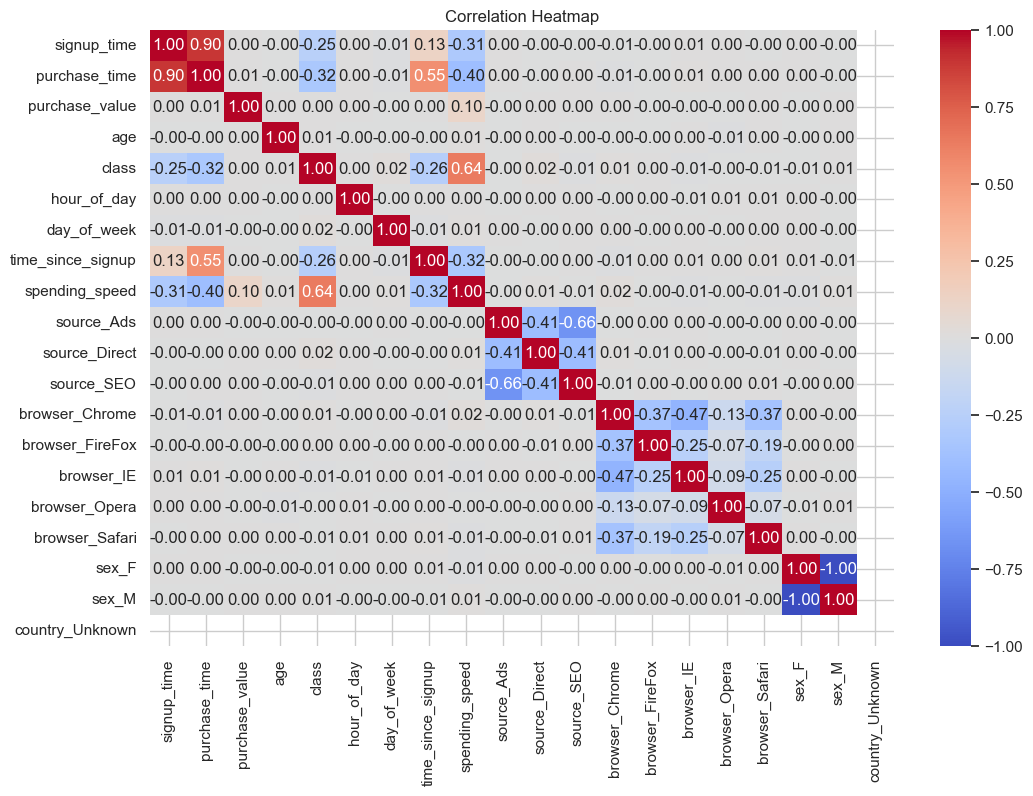

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(df_fraud.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


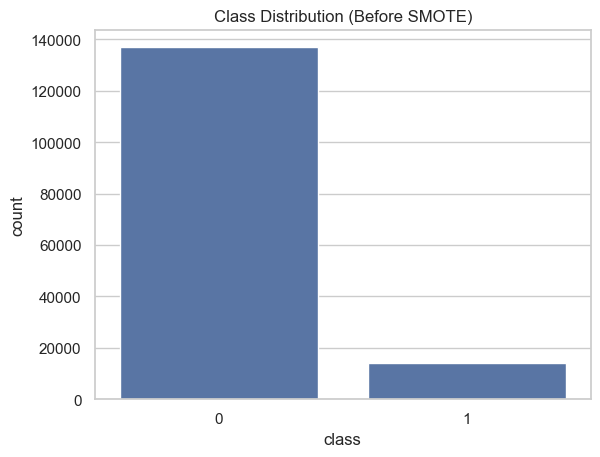

In [9]:
sns.countplot(x='class', data=df_fraud)
plt.title("Class Distribution (Before SMOTE)")
plt.show()


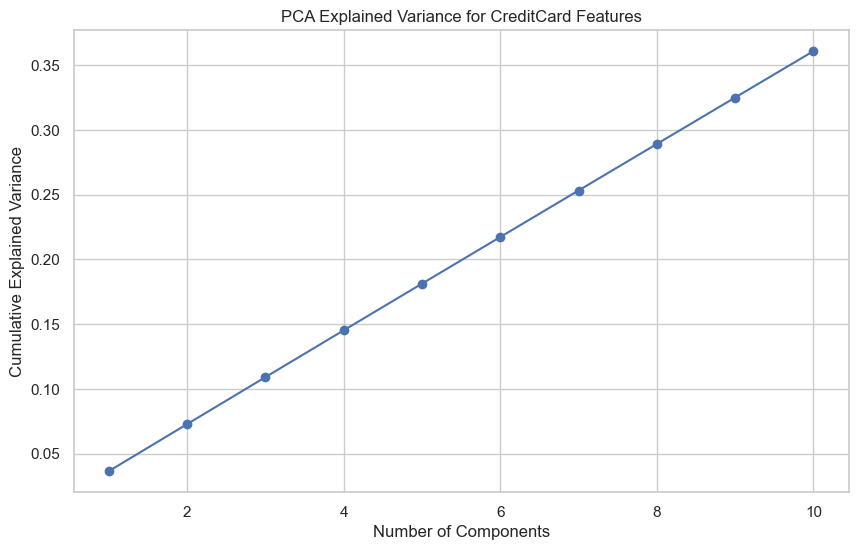

In [10]:
X_credit = df_credit[[f"V{i}" for i in range(1,29)]]
X_credit_scaled = scaler.fit_transform(X_credit)

pca = PCA(n_components=10)
pca.fit(X_credit_scaled)

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance for CreditCard Features")
plt.grid(True)
plt.show()


Dropping datetime columns for SMOTE: ['signup_time', 'purchase_time']
Original class distribution: Counter({0: 136961, 1: 14151})
Resampled class distribution: Counter({0: 136961, 1: 136961})


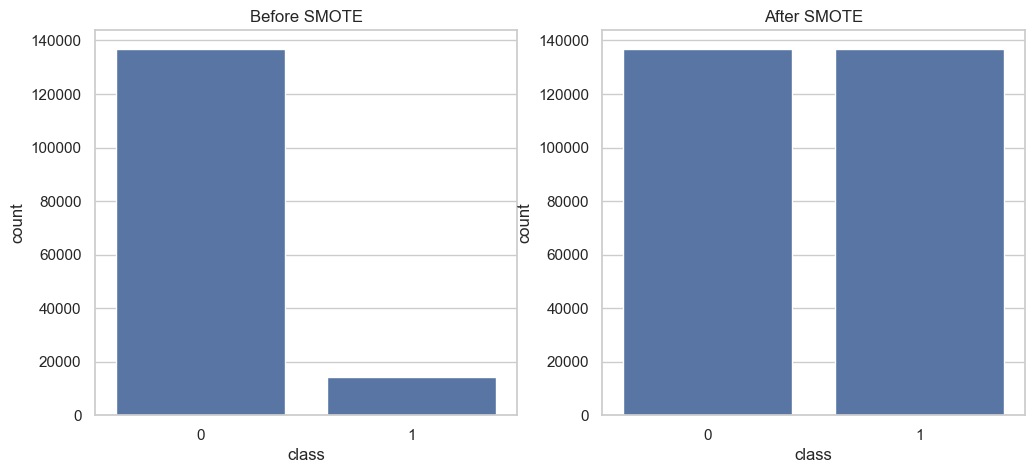

In [12]:
from collections import Counter

# Separate target
X = df_fraud.drop(columns=['class'])
y = df_fraud['class']

# Drop datetime columns before resampling
datetime_cols = X.select_dtypes(include=['datetime64[ns]']).columns.tolist()
if datetime_cols:
    print("Dropping datetime columns for SMOTE:", datetime_cols)
    X = X.drop(columns=datetime_cols)

print("Original class distribution:", Counter(y))

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

df_resampled = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name='class')], axis=1)
print("Resampled class distribution:", Counter(y_res))

# Visual comparison
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.countplot(x='class', data=df_fraud, ax=axes[0])
axes[0].set_title("Before SMOTE")
sns.countplot(x='class', data=df_resampled, ax=axes[1])
axes[1].set_title("After SMOTE")
plt.show()


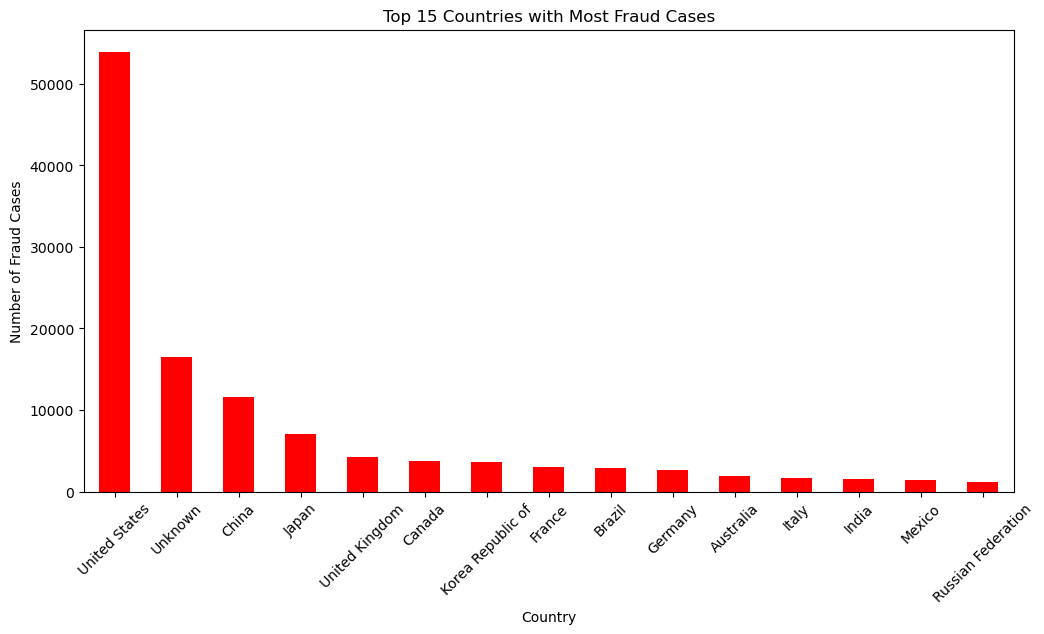

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your fraud dataset
df_fraud = pd.read_csv("../data/processed/enhanced_processed_fraud_data.csv")

# Extract country columns
country_cols = [col for col in df_fraud.columns if col.startswith("country_")]

# Reconstruct a single 'country' column from one-hot encoding
df_fraud['country'] = df_fraud[country_cols].idxmax(axis=1).str.replace("country_", "")

# Fraud by country
fraud_country = df_fraud.groupby('country')['class'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
fraud_country.head(15).plot(kind='bar', color='red')
plt.title("Top 15 Countries with Most Fraud Cases")
plt.xlabel("Country")
plt.ylabel("Number of Fraud Cases")
plt.xticks(rotation=45)
plt.show()
